In [31]:
import random
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report

# set this variable to a number to be used as the random seed
# or to None if you don't want to set a random seed
seed = 1234

if seed is not None:
    random.seed(seed)
    np.random.seed(seed)

In [32]:
education_data = pd.read_csv('students_clean.csv')


education_data.drop('Parent_Education_Level', axis=1, inplace=True) 

education_data['Gender'] = education_data['Gender'].replace({'Male': 1, 'Female': 0}).astype(int)
education_data['Internet_Access_at_Home'] = education_data['Internet_Access_at_Home'].replace({'Yes': 1, 'No': 0}).astype(int)
education_data['Extracurricular_Activities'] = education_data['Extracurricular_Activities'].replace({'Yes': 1, 'No': 0}).astype(int)


# Low = 1, Medium = 2, High = 3
mapper = {'low': 1, 'medium': 2, 'high': 3}

education_data['Family_Income_Level'] = (
    education_data['Family_Income_Level']
      .astype(str)                  # works even if the value is already 1/2/3 or NaN
      .str.strip().str.lower()
      .map(mapper)                  # returns NaN where no mapping found
      .fillna(education_data['Family_Income_Level'])  # keepin the original numeric/blank entries
      .astype('Int64')              #  nullable integer dtype
)

labels = open('departments.txt').read().splitlines()
department_mapping = {name: index for index, name in enumerate(labels)}
department_indices = education_data['Department'].map(department_mapping)
education_data.insert(3, 'department index', department_indices)

mapper = {'A': 1, 'B': 1, 'C': 1, 'D':0,'F':0}

education_data['Grade'] = (
    education_data['Grade']
      .astype(str)              # convert everything to string
      .str.strip().str.upper()  # remove spaces and standardize to uppercase
      .map(mapper)              # map letters to numbers
)

education_data.head()

/tmp/ipykernel_924246/1122780081.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  education_data['Gender'] = education_data['Gender'].replace({'Male': 1, 'Female': 0}).astype(int)
/tmp/ipykernel_924246/1122780081.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  education_data['Internet_Access_at_Home'] = education_data['Internet_Access_at_Home'].replace({'Yes': 1, 'No': 0}).astype(int)
/tmp/ipykernel_924246/1122780081.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version

,Gender,Age,Department,department index,Attendance (%),Midterm_Score,Final_Score,Assignments_Avg,Quizzes_Avg,Participation_Score,Projects_Score,Total_Score,Grade,Study_Hours_per_Week,Extracurricular_Activities,Internet_Access_at_Home,Family_Income_Level,Stress_Level (1-10),Sleep_Hours_per_Night
0,0,22,Mathematics,0,97.36,40.61,59.61,73.69,53.17,73.4,62.84,59.8865,0,10.3,1,0,2,1,5.9
1,1,18,Business,1,97.71,57.27,74.00,74.23,98.23,88.0,98.23,81.9170,1,27.1,0,0,1,4,4.3
2,1,24,Engineering,2,99.52,41.84,63.85,85.85,50.00,4.7,91.22,67.7170,0,12.4,1,0,1,9,6.1
3,0,24,Engineering,2,90.38,45.65,44.44,68.10,66.27,4.2,55.48,51.6535,0,25.5,0,1,1,8,4.9
4,0,23,CS,3,59.41,53.13,61.77,67.66,83.98,64.3,87.43,71.4030,1,13.3,1,0,2,6,4.5


In [33]:

education_data = education_data.drop(columns=['Department'])
corr_df = education_data.corr(method='pearson')[['Grade']]
corr_df['Grade_Corr_Abs'] = corr_df['Grade'].apply(lambda x: np.abs(x))
corr_df = corr_df.sort_values(by='Grade_Corr_Abs',ascending=False)
corr_df

,Grade,Grade_Corr_Abs
Grade,1.000000,1.000000
Total_Score,0.801708,0.801708
Final_Score,0.481276,0.481276
Projects_Score,0.473152,0.473152
Assignments_Avg,0.265017,0.265017
Midterm_Score,0.251470,0.251470
Quizzes_Avg,0.156222,0.156222
Participation_Score,0.150405,0.150405
Stress_Level (1-10),0.020894,0.020894
Sleep_Hours_per_Night,0.010893,0.010893


In [34]:
corr_df.index[1:11]

Index(['Total_Score', 'Final_Score', 'Projects_Score', 'Assignments_Avg',
       'Midterm_Score', 'Quizzes_Avg', 'Participation_Score',
       'Stress_Level (1-10)', 'Sleep_Hours_per_Night',
       'Extracurricular_Activities'],
      dtype='object')

In [35]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(education_data, train_size=0.8)
train_df,dev_df = train_test_split(train_df, train_size=0.8)

train_df.reset_index(inplace=True,drop=True)
dev_df.reset_index(inplace=True,drop=True)
test_df.reset_index(inplace=True,drop=True)

In [36]:
def create_datasets(feature_names):
    train_x = train_df[feature_names]
    train_y = train_df[['Grade']]

    dev_x = dev_df[feature_names]
    dev_y = dev_df[['Grade']]

    test_x = test_df[feature_names]
    test_y = test_df[['Grade']]

    return (train_x,train_y,dev_x,dev_y,test_x,test_y)

def train_desic_tree(train_x,train_y):
    desic_tree = DecisionTreeClassifier(random_state=42,max_leaf_nodes=10)
    desic_tree.fit(train_x,train_y)
    return desic_tree

In [37]:
# For part a

features_names_a = ['Assignments_Avg',
       'Quizzes_Avg', 'Participation_Score',
       'Stress_Level (1-10)', 'Sleep_Hours_per_Night',
       'Extracurricular_Activities','Attendance (%)']
train_x_a,train_y_a,dev_x_a,dev_y_a,test_x_a,test_y_a = create_datasets(features_names_a)

before_midterm_tree = train_desic_tree(train_x_a,train_y_a)

# For part b
features_names_b = ['Assignments_Avg',
       'Midterm_Score', 'Quizzes_Avg', 'Participation_Score',
       'Stress_Level (1-10)', 'Sleep_Hours_per_Night',
       'Extracurricular_Activities','Attendance (%)']
train_x_b,train_y_b,dev_x_b,dev_y_b,test_x_b,test_y_b = create_datasets(features_names_b)

after_midterm_tree = train_desic_tree(train_x_b,train_y_b)


# For part c
features_names_c = ['Final_Score','Projects_Score','Assignments_Avg',
       'Midterm_Score', 'Quizzes_Avg', 'Participation_Score',
       'Stress_Level (1-10)', 'Sleep_Hours_per_Night',
       'Extracurricular_Activities','Attendance (%)']
train_x_c,train_y_c,dev_x_c,dev_y_c,test_x_c,test_y_c = create_datasets(features_names_c)

after_final_tree = train_desic_tree(train_x_c,train_y_c)



# For before the midterm

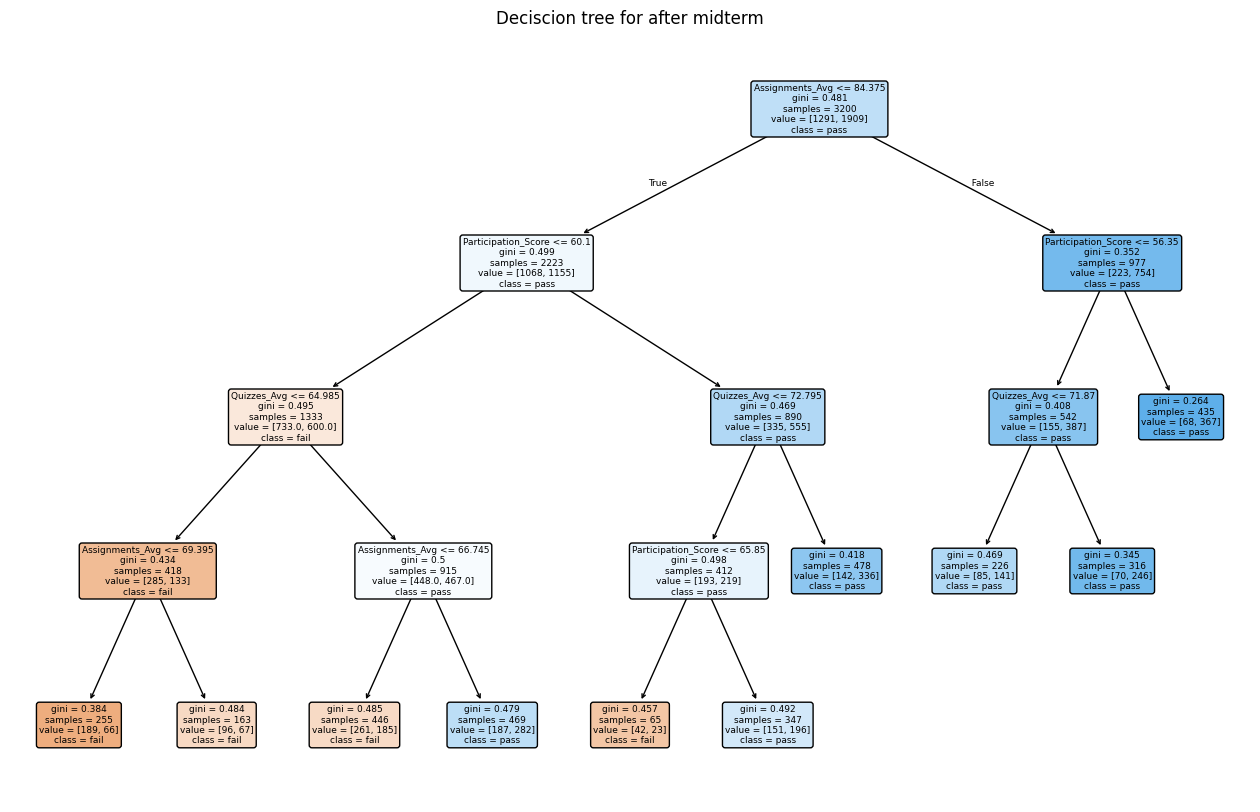

In [38]:
# Visualize before midterm
plt.figure(figsize=(16, 10))
plot_tree(
    before_midterm_tree,
    filled=True,
    feature_names=features_names_a,
    class_names=['fail','pass'],
    rounded=True
)
plt.title("Deciscion tree for after midterm")
plt.show()

In [39]:
print(classification_report(dev_y_a,before_midterm_tree.predict(dev_x_a)))

              precision    recall  f1-score   support

           0       0.59      0.40      0.47       338
           1       0.64      0.80      0.71       462

    accuracy                           0.63       800
   macro avg       0.62      0.60      0.59       800
weighted avg       0.62      0.63      0.61       800



In [40]:
print(classification_report(test_y_a,before_midterm_tree.predict(test_x_a)))

              precision    recall  f1-score   support

           0       0.58      0.43      0.49       410
           1       0.66      0.78      0.72       590

    accuracy                           0.64      1000
   macro avg       0.62      0.61      0.61      1000
weighted avg       0.63      0.64      0.63      1000



# For after the midterm

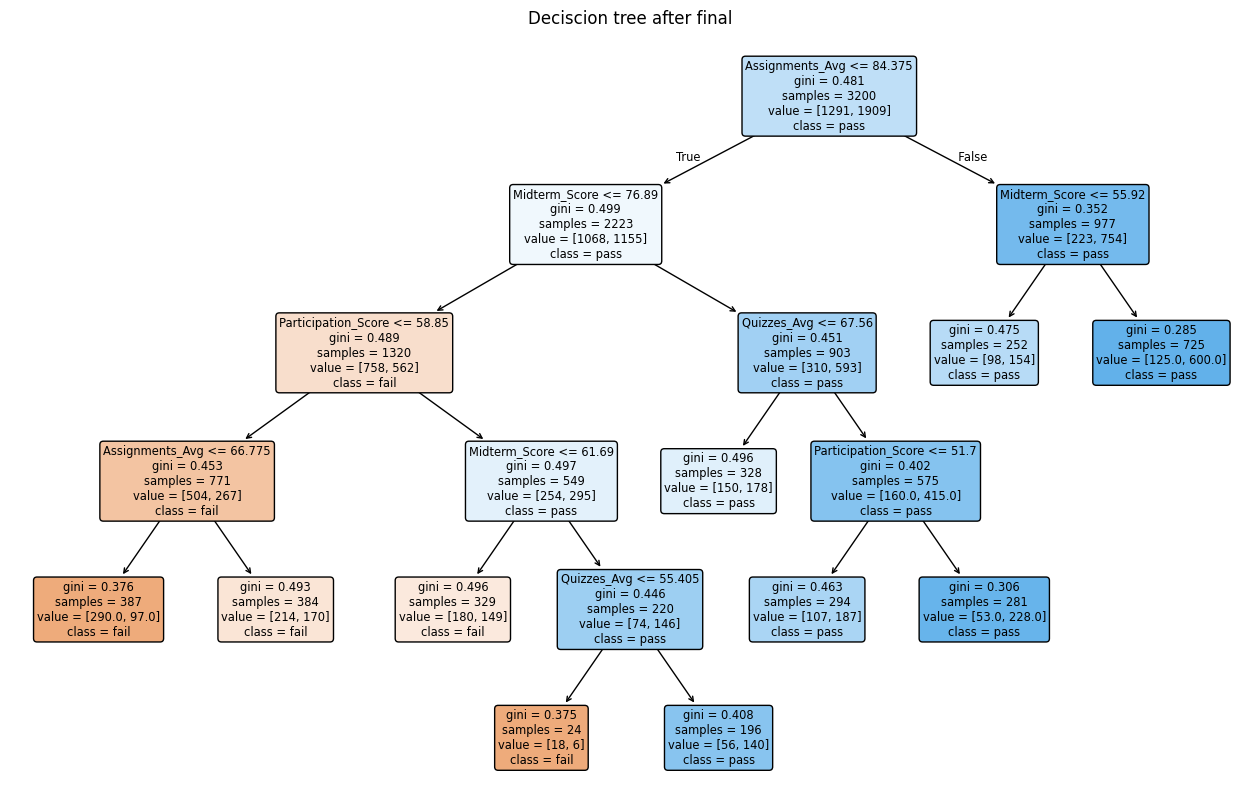

In [41]:
# Visualize after midterm
plt.figure(figsize=(16, 10))
plot_tree(
    after_midterm_tree,
    filled=True,
    feature_names=features_names_b,
    class_names=['fail','pass'],
    rounded=True
)
plt.title("Deciscion tree after final")
plt.show()

In [16]:
print(classification_report(dev_y_b,after_midterm_tree.predict(dev_x_b)))

              precision    recall  f1-score   support

           0       0.63      0.50      0.56       338
           1       0.68      0.79      0.73       462

    accuracy                           0.67       800
   macro avg       0.66      0.64      0.65       800
weighted avg       0.66      0.67      0.66       800



In [17]:
print(classification_report(test_y_b,after_midterm_tree.predict(test_x_b)))

              precision    recall  f1-score   support

           0       0.63      0.55      0.59       410
           1       0.71      0.78      0.74       590

    accuracy                           0.68      1000
   macro avg       0.67      0.66      0.66      1000
weighted avg       0.68      0.68      0.68      1000



# After the final

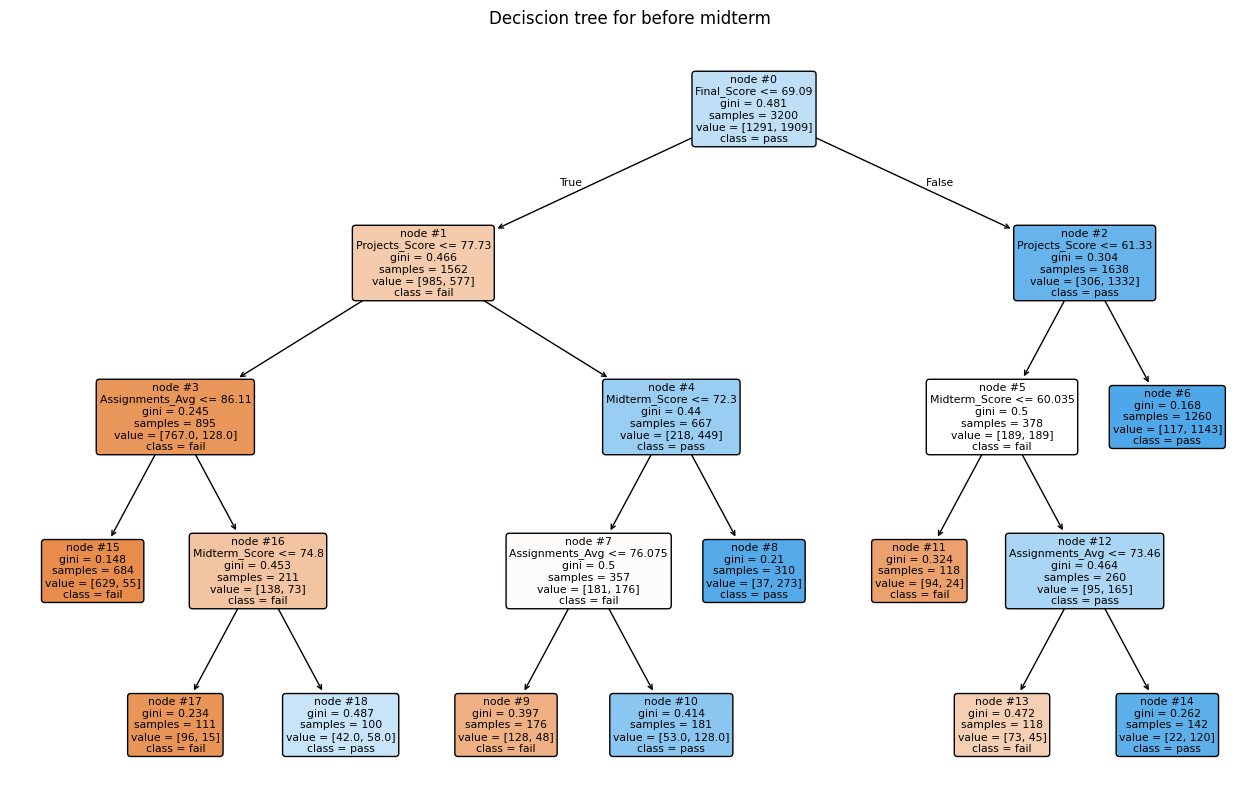

In [18]:
# Visualize after final
plt.figure(figsize=(16, 10))
plot_tree(
    after_final_tree,
    filled=True,
    feature_names=features_names_c,
    class_names=['fail','pass'],
    rounded=True,
    node_ids=True
)
plt.title("Deciscion tree for before midterm")
plt.show()

In [19]:
print(classification_report(dev_y_c,after_final_tree.predict(dev_x_c)))

              precision    recall  f1-score   support

           0       0.82      0.75      0.78       338
           1       0.83      0.88      0.85       462

    accuracy                           0.82       800
   macro avg       0.82      0.82      0.82       800
weighted avg       0.82      0.82      0.82       800



In [20]:
print(classification_report(dev_y_c,after_final_tree.predict(dev_x_c)))

              precision    recall  f1-score   support

           0       0.82      0.75      0.78       338
           1       0.83      0.88      0.85       462

    accuracy                           0.82       800
   macro avg       0.82      0.82      0.82       800
weighted avg       0.82      0.82      0.82       800



In [42]:
false_ng_ex = pd.read_csv('false_negatives_10.csv')
false_ng_ex

,Attendance (%),Extracurricular_Activities,Midterm_Score,Final_Score,Assignments_Avg,Quizzes_Avg,Participation_Score,Projects_Score,Stress_Level (1-10),Sleep_Hours_per_Night,Grade
0,92.88,0,45.43,51.62,94.52,74.45,83.6,83.54,6,7.0,1
1,89.28,1,49.40,55.45,99.21,76.10,8.9,94.94,9,5.0,1
2,98.37,1,69.31,83.73,59.24,96.39,26.3,78.55,1,5.7,1
3,99.74,0,49.34,77.04,90.94,80.54,23.3,71.73,9,7.1,1
4,94.61,1,63.65,42.46,96.12,87.54,69.8,82.35,10,8.3,1
5,83.61,0,64.38,66.03,94.07,80.25,49.3,64.69,7,4.7,1
6,94.06,1,63.13,65.12,73.78,98.67,51.5,89.56,2,5.4,1
7,81.75,0,52.50,50.77,99.80,97.27,77.9,81.44,9,6.2,1
8,91.93,1,60.32,57.32,81.96,97.36,62.7,87.54,5,5.5,1
9,95.08,0,60.07,85.51,90.52,95.65,42.1,50.33,8,7.0,1


In [43]:
false_pos_ex = pd.read_csv('false_positives_15.csv')

In [44]:
false_ng_test = false_ng_ex.copy()
false_ng_test.columns

Index(['Attendance (%)', 'Extracurricular_Activities', 'Midterm_Score',
       'Final_Score', 'Assignments_Avg', 'Quizzes_Avg', 'Participation_Score',
       'Projects_Score', 'Stress_Level (1-10)', 'Sleep_Hours_per_Night',
       'Grade'],
      dtype='object')

In [45]:
false_ng_test_x = false_ng_test[['Final_Score','Projects_Score','Assignments_Avg',
       'Midterm_Score', 'Quizzes_Avg', 'Participation_Score',
       'Stress_Level (1-10)', 'Sleep_Hours_per_Night',
       'Extracurricular_Activities','Attendance (%)']]
false_ng_test_y = false_ng_test[['Grade']]

In [46]:
node_indicator = after_final_tree.decision_path(false_ng_test_x)

for idx in range(false_ng_test_x.shape[0]):
    node_indices = node_indicator.indices[
        node_indicator.indptr[idx] : node_indicator.indptr[idx + 1]
    ]
    print(f"Sample {idx} went through: {node_indices}")

Sample 0 went through: [ 0  1  4  7 10]
Sample 1 went through: [ 0  1  4  7 10]
Sample 2 went through: [0 2 6]
Sample 3 went through: [0 2 6]
Sample 4 went through: [ 0  1  4  7 10]
Sample 5 went through: [ 0  1  3 16 17]
Sample 6 went through: [0 1 4 7 9]
Sample 7 went through: [ 0  1  4  7 10]
Sample 8 went through: [ 0  1  4  7 10]
Sample 9 went through: [ 0  2  5 12 14]


In [47]:
false_pos_test = false_pos_ex.copy()

false_pos_test_x = false_pos_test[['Final_Score','Projects_Score','Assignments_Avg',
       'Midterm_Score', 'Quizzes_Avg', 'Participation_Score',
       'Stress_Level (1-10)', 'Sleep_Hours_per_Night',
       'Extracurricular_Activities','Attendance (%)']]
false_pos_test_y = false_pos_test[['Grade']]

node_indicator = after_final_tree.decision_path(false_pos_test_x)

for idx in range(false_pos_test_x.shape[0]):
    node_indices = node_indicator.indices[
        node_indicator.indptr[idx] : node_indicator.indptr[idx + 1]
    ]
    print(f"Sample {idx} went through: {node_indices}")

Sample 0 went through: [0 2 6]
Sample 1 went through: [0 2 6]
Sample 2 went through: [ 0  1  3 15]
Sample 3 went through: [ 0  1  3 15]
Sample 4 went through: [0 2 6]
Sample 5 went through: [ 0  1  3 15]
Sample 6 went through: [ 0  1  3 15]
Sample 7 went through: [ 0  2  5 12 13]
Sample 8 went through: [ 0  1  3 15]
Sample 9 went through: [ 0  1  3 15]
Sample 10 went through: [0 1 4 8]
Sample 11 went through: [ 0  1  3 15]
Sample 12 went through: [ 0  1  3 16 17]
Sample 13 went through: [0 1 4 7 9]
Sample 14 went through: [ 0  2  5 11]


In [48]:
false_ng_test.iloc[3]

Attendance (%)                99.74
Extracurricular_Activities     0.00
Midterm_Score                 49.34
Final_Score                   77.04
Assignments_Avg               90.94
Quizzes_Avg                   80.54
Participation_Score           23.30
Projects_Score                71.73
Stress_Level (1-10)            9.00
Sleep_Hours_per_Night          7.10
Grade                          1.00
Name: 3, dtype: float64

In [49]:
false_pos_ex

,Attendance (%),Extracurricular_Activities,Midterm_Score,Final_Score,Assignments_Avg,Quizzes_Avg,Participation_Score,Projects_Score,Stress_Level (1-10),Sleep_Hours_per_Night,Grade
0,92.68,1,60.33,70.99,85.67,55.46,5.7,76.40,3,8.2,0
1,70.32,1,41.14,83.66,66.76,61.46,68.2,62.64,8,4.4,0
2,52.96,0,78.38,55.22,60.21,76.98,82.2,69.37,1,8.0,0
3,68.14,1,95.82,56.38,69.11,74.48,64.0,56.80,7,6.9,0
4,66.87,0,72.25,88.65,54.94,77.86,13.3,66.85,6,6.2,0
5,68.47,1,57.07,60.64,53.66,85.30,26.5,74.31,10,8.7,0
6,57.46,0,47.28,51.52,57.06,88.44,72.3,51.13,1,6.4,0
7,65.60,0,76.57,75.55,54.99,54.26,21.3,53.73,8,7.3,0
8,56.27,1,68.07,42.62,67.12,61.10,86.7,62.50,4,7.5,0
9,60.67,1,48.42,62.72,83.03,52.81,46.0,63.23,7,5.9,0


In [50]:
false_ng_ex

,Attendance (%),Extracurricular_Activities,Midterm_Score,Final_Score,Assignments_Avg,Quizzes_Avg,Participation_Score,Projects_Score,Stress_Level (1-10),Sleep_Hours_per_Night,Grade
0,92.88,0,45.43,51.62,94.52,74.45,83.6,83.54,6,7.0,1
1,89.28,1,49.40,55.45,99.21,76.10,8.9,94.94,9,5.0,1
2,98.37,1,69.31,83.73,59.24,96.39,26.3,78.55,1,5.7,1
3,99.74,0,49.34,77.04,90.94,80.54,23.3,71.73,9,7.1,1
4,94.61,1,63.65,42.46,96.12,87.54,69.8,82.35,10,8.3,1
5,83.61,0,64.38,66.03,94.07,80.25,49.3,64.69,7,4.7,1
6,94.06,1,63.13,65.12,73.78,98.67,51.5,89.56,2,5.4,1
7,81.75,0,52.50,50.77,99.80,97.27,77.9,81.44,9,6.2,1
8,91.93,1,60.32,57.32,81.96,97.36,62.7,87.54,5,5.5,1
9,95.08,0,60.07,85.51,90.52,95.65,42.1,50.33,8,7.0,1
